In [1]:
import nistats
import nibabel as nib
import nilearn
from nistats.first_level_model import FirstLevelModel
from nistats.second_level_model import SecondLevelModel
from nilearn.plotting import plot_stat_map
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl

%matplotlib inline

In [2]:
## get events
behavior = pd.read_pickle('./derivatives/behavior.pkl')
behavior['sub'] = behavior['subject']
behavior.loc[behavior['ds']=='ds-02', 'sub'] = behavior.loc[behavior['ds']=='ds-02', 'sub'].astype(int) + behavior.loc[behavior['ds']=='ds-01', 'sub'].astype(int).max()
behavior['sub'] = behavior['sub'].astype(int)
behavior['onset_response'] = behavior['onset_stim'] + behavior['rt']/1000
behavior = behavior.loc[behavior.response.isin([1,2])]  # remove errors

events_cue = behavior[['sub', 'block', 'cue', 'onset_cue']]
events_cue['event_type'] = events_cue['cue'].apply(lambda x: 'cue_' + x)
events_cue = events_cue.rename(columns={'block': 'run', 'onset_cue': 'onset'})

events_stim = behavior[['sub', 'block', 'difficulty', 'onset_stim']]
events_stim = events_stim.rename(columns={'block': 'run', 'onset_stim': 'onset', 'difficulty': 'event_type'})

events_responses = behavior[['sub', 'block', 'response', 'onset_response']]
events_responses['event_type'] = events_responses['response'].replace({1: 'response_left', 2: 'response_right', -1: 'error'})
events_responses = events_responses.rename(columns={'block': 'run', 'onset_response': 'onset'})

events = pd.concat((events_cue, events_stim, events_responses))
events = events.sort_values(by=['sub', 'run', 'onset'])
events = events.rename(columns={'sub': 'subject'})

events = events.set_index(['subject', 'run'])[['onset', 'event_type']].rename(columns={'event_type': 'trial_type'})
events['duration'] = 0.001
events.head()

# ## correct onsets due to STC
# events_deconv['onset'] -= 1.5

/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


onset     trial_type  duration
subject run                                 
1       1     7.500       cue_left     0.001
        1    10.250           easy     0.001
        1    11.321  response_left     0.001
        1    16.500       cue_left     0.001
        1    19.250           hard     0.001

In [3]:
## get confounds
all_csvs = glob.glob('./derivatives/ds-*/fmriprep_confounds/sub-*_task-randomdotmotion_run-*_desc-confounds_regressors.tsv')

reg = re.compile('.*ds-(?P<ds>\d+)/fmriprep_confounds/sub-(?P<sub>\d+)_.*_run-(?P<run>\d+)_.*')
reg.match(all_csvs[1]).groupdict()


confounds_df = []

# loop over .csv-files, adding signal row-by-row
for fn in all_csvs:
    d = reg.match(fn).groupdict()
    tmp = pd.read_csv(fn, sep='\t')
    tmp['sub'] = d['sub']
    tmp['run'] = d['run']
    tmp['ds'] = d['ds']
    confounds_df.append(tmp)

confounds_df = pd.concat(confounds_df, axis=0)
confounds_df['ds'] = confounds_df['ds'].astype(int)
confounds_df['run'] = confounds_df['run'].astype(int)
confounds_df['subject'] = confounds_df['sub'].astype(int)

# adjust ds2 subject idx to ensure non-overlapping subject idx
max_sub_ds1 = confounds_df.loc[confounds_df.ds==1,'subject'].max()
confounds_df.loc[confounds_df.ds==2,'subject'] = confounds_df.loc[confounds_df.ds==2,'subject']+max_sub_ds1
confounds_df = confounds_df.sort_values(['ds', 'subject', 'run']).set_index(['ds', 'subject', 'run'])

# Include confounds: 5 ACompCor regressors, cosines for drift, DVARS, rotation & translation params
confounds_deconv = confounds_df.reset_index(level=0, drop=True)
include_confounds = ['a_comp_cor_0' + str(x) for x in range(5)] #+ ['cosine' + str(x).zfill(2) for x in range(17)]
#include_confounds = include_confounds + ['dvars', 'framewise_displacement']
include_confounds = include_confounds + ['rot_' + a for a in ['x', 'y', 'z']]
include_confounds = include_confounds + ['trans_' + a for a in ['x', 'y', 'z']]
confounds_deconv = confounds_deconv[include_confounds]

In [4]:
def get_confounds(sub, run, confounds):
    return confounds.loc[sub, run]

def get_events(sub, run, events, onset_shift=-1.5):
    events_ = events.loc[sub, run]
    events_['onset'] += onset_shift
    return events_

def get_sub_n(sub, max_sub_ds1=19):
    if sub > max_sub_ds1:
        sub -= max_sub_ds1
        ds = 2
    else:
        ds = 1
    return ds, sub

def get_niis(sub, run, max_sub_ds1=19):
    ds, sub = get_sub_n(sub)
    sub_str = str(sub).zfill(2)
    run_str = str(run).zfill(2)
    ds_str = str(ds).zfill(2)
    fn = './derivatives/ds-{ds_str}/fmriprep/sub-{sub_str}/func/sub-{sub_str}_task-randomdotmotion_run-{run_str}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'.format(**locals())
    return fn

def get_brain_mask(sub, run):
    ds, sub = get_sub_n(sub)
    sub_str = str(sub).zfill(2)
    run_str = str(run).zfill(2)
    ds_str = str(ds).zfill(2)
    fn = './derivatives/ds-{ds_str}/fmriprep/sub-{sub_str}/func/sub-{sub_str}_task-randomdotmotion_run-{run_str}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(**locals())
    return fn

## test run for single subject
with smoothing

In [5]:
sub = 1

onset_shift = -1.5  # should be best

events_ = [get_events(sub, run, events=events, onset_shift=onset_shift).reset_index(drop=True) for run in [1,2,3]]
confounds_ = [confounds_deconv.loc[sub,run].reset_index(drop=True) for run in [1,2,3]]
bold_niis = [nib.load(get_niis(sub, run)) for run in [1,2,3]]
brain_mask = nib.load(get_brain_mask(sub, 1))

fmri_glm = FirstLevelModel(t_r=3., 
                           smoothing_fwhm=5,
                           slice_time_ref=0,
                           mask=brain_mask,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='glover + derivative',
                           drift_model='Cosine',
                           n_jobs=-5)

/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


In [53]:
fmri_glm.fit(bold_niis, events_, confounds_)

FirstLevelModel(drift_model='Cosine', drift_order=1, fir_delays=[0],
        high_pass=0.01, hrf_model='glover + derivative',
        mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f8683183240>,
        memory=Memory(location=None), memory_level=1, min_onset=-24,
        minimize_memory=True, n_jobs=-5, noise_model='ar1',
        signal_scaling=True, slice_time_ref=0, smoothing_fwhm=5,
        standardize=False, subject_label=None, t_r=3.0, target_affine=None,
        target_shape=None, verbose=0)

In [55]:
z = fmri_glm.compute_contrast('response_left - response_right')

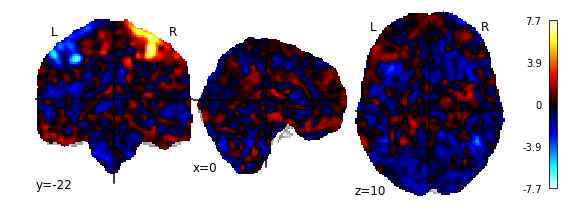

In [56]:
plot_stat_map(z)

That looks good.

## loop first-levels

In [6]:
for onset_shift in [-1.5, -3, -4.5, 0]:
    for sub in np.arange(1, 35):
        print(sub)
        pkl_name = 'sub-{}_shift-{}_glm.pkl'.format(sub, onset_shift)
        if os.path.exists(os.path.join('models_sm', pkl_name)):
            continue
        
        if sub == 23:   #doesn't exist?
            continue
        
        runs = list(events.loc[sub].index.unique())        
        events_ = [get_events(sub, run, events=events, onset_shift=onset_shift).reset_index(drop=True) for run in runs]
        confounds_ = [confounds_deconv.loc[sub,run].reset_index(drop=True) for run in runs]
        bold_niis = [nib.load(get_niis(sub, run)) for run in runs]
        brain_mask = nib.load(get_brain_mask(sub, 1))

        fmri_glm = FirstLevelModel(t_r=3., 
                                   smoothing_fwhm=None,
                                   slice_time_ref=0,
                                   mask=brain_mask,
                                   noise_model='ar1',
                                   standardize=False,
                                   hrf_model='glover + derivative',
                                   drift_model='Cosine',
                                   n_jobs=-5)
        fmri_glm.fit(bold_niis, events_, confounds_)
        
        with open(os.path.join('models_sm', pkl_name), 'wb') as f:
            pkl.dump(fmri_glm, f, protocol=4)

/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
1
2


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


3


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


4


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


5


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


6


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


7


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


8


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


9


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


10


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


11


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


12


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


13


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


14


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


15


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


16


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


17


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


18


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


19


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


20


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


21


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


22


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


23
24


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


25


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


26


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


27


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


28


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


29


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


30


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


31


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


32


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


33


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


34


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


1


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


2


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


3


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


4


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


5


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


6


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


7


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


8


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


9


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


10


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


11


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


12


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


13


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


14


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


15


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


16


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


17


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


18


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


19


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


20


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


21


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


22


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


23
24


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


25


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


26


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


27


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


28


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


29


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


30


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


31


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


32


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


33


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


34


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


1


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


2


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


3


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


4


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


5


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


6


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


7


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


8


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


9


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


10


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


11


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


12


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


13


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


14


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


15


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


16


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


17


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


18


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


19


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


20


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


21


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


22


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


23
24


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


25


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


26


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


27


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


28


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/stevenm/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executo

29


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


30


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


31


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


32


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


33


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


34


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:70: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
